In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

# <font color='red'>**Drive Mount**</font>
---

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# <font color='red'>**Load Data from drive**</font>
---

In [4]:
#Load Training data
df_train = pd.read_csv('/content/drive/My Drive/data/Shentiment_Analysis/train_sentiment.csv', encoding='ISO-8859-1')
print(df_train.head(3))

#Load Testing data
df_test=df_train = pd.read_csv('/content/drive/My Drive/data/Shentiment_Analysis/test_sentiment.csv', encoding= 'unicode_escape')
print(df_train.head(3))

                                             text sentiment
0             I`d have responded, if I were going   neutral
1   Sooo SAD I will miss you here in San Diego!!!  negative
2                       my boss is bullying me...  negative
                                                text sentiment
0  Last session of the day  http://twitpic.com/67ezh   neutral
1   Shanghai is also really exciting (precisely -...  positive
2  Recession hit Veronique Branquinho, she has to...  negative


In [5]:
print(df_train.shape)
print(df_test.shape)

(3534, 2)
(3534, 2)


# <font color='red'>**Drop duplicate data**</font>
---

In [6]:
#For Training Data
df_train.drop_duplicates(inplace = True) 
print(df_train.head(3))
print(df_train.shape)


                                                text sentiment
0  Last session of the day  http://twitpic.com/67ezh   neutral
1   Shanghai is also really exciting (precisely -...  positive
2  Recession hit Veronique Branquinho, she has to...  negative
(3534, 2)


In [7]:
#For Testing Data
df_test.drop_duplicates(inplace = True) 
print(df_test.head(3))
print(df_test.shape)

                                                text sentiment
0  Last session of the day  http://twitpic.com/67ezh   neutral
1   Shanghai is also really exciting (precisely -...  positive
2  Recession hit Veronique Branquinho, she has to...  negative
(3534, 2)


<font color='red'>**Representation of train dataset frequency based on sentiment column**</font>
---

In [8]:
from collections import Counter
Train_sentiment_counts = Counter(df_train.sentiment)
print(Train_sentiment_counts)

Counter({'neutral': 1430, 'positive': 1103, 'negative': 1001})


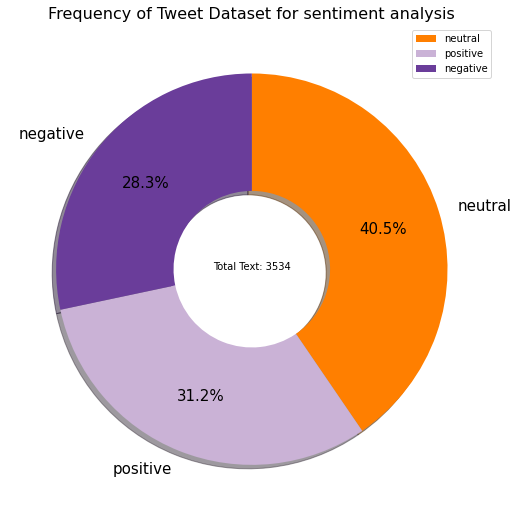

In [9]:
plt.figure(figsize = (9,9))
sorted_counts = df_train['sentiment'].value_counts()
plt.pie(sorted_counts, labels = sorted_counts.index, startangle = 90, counterclock = False, wedgeprops = {'width' : 0.6},
       autopct='%1.1f%%', pctdistance = 0.7, textprops = {'color': 'black', 'fontsize' : 15}, shadow = True,
        colors = sns.color_palette("Paired")[7:])
plt.text(x = -0.20, y = 0, s = 'Total Text: {}'.format(df_train['sentiment'].shape[0]))
plt.title('Frequency of Tweet Dataset for sentiment analysis', fontsize = 16);
plt.legend(loc='upper right')

<font color='red'>**Representation of test dataset frequency based on sentiment column**</font>
---


In [10]:
Test_sentiment_counts = Counter(df_test.sentiment)
print(Test_sentiment_counts)

Counter({'neutral': 1430, 'positive': 1103, 'negative': 1001})


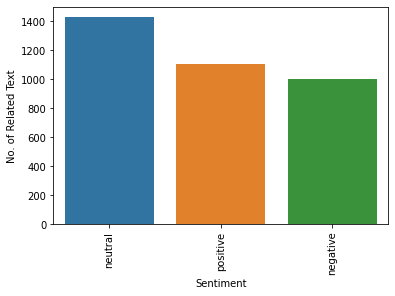

In [11]:
data = {'neutral': 1430, 'positive': 1103, 'negative': 1001}
# convert dictionary to dataframe
df = pd.DataFrame(list(data.items()), columns=["Sentiment", "No. of Related Text"])

# create bar chart
sns.barplot(x="Sentiment", y="No. of Related Text", data=df)
plt.xticks(rotation=90)
plt.show()

<font color='red'>Droping Neutral type Text</font>
---

In [12]:
df_test = df_test[df_test['sentiment'] != 'neutral']
df_test.head()
df_train = df_train[df_train['sentiment'] != 'neutral']
df_train.head()

,text,sentiment
1,Shanghai is also really exciting (precisely -...,positive
2,"Recession hit Veronique Branquinho, she has to...",negative
3,happy bday!,positive
4,http://twitpic.com/4w75p - I like it!!,positive
5,that`s great!! weee!! visitors!,positive


In [13]:
class Sequences(Dataset):
    def __init__(self, data):
        self.vectorizer = CountVectorizer(stop_words='english')
        self.sequences = self.vectorizer.fit_transform(data.text.tolist())
        self.labels = data.sentiment.tolist()
        self.token2idx = self.vectorizer.vocabulary_
        self.idx2token = {idx: token for token, idx in self.token2idx.items()}
    
    def __getitem__(self, i):
        return self.sequences[i, :].toarray(), self.labels[i]
    
    def __len__(self):
        return self.sequences.shape[0]


<font color='red'>***For Positive sentimnet set as 1***<font/>
---
<font color='red'>***For Negative sentimnet set as 0***<font/>
---

In [14]:
#for training data
codes=[0,1]
df_train.columns = ["text", "sentiment"]
df_train["sentiment"] = df_train["sentiment"].astype('category')
df_train["sentiment"] = df_train["sentiment"].cat.codes
df_train.head(3)

,text,sentiment
1,Shanghai is also really exciting (precisely -...,1
2,"Recession hit Veronique Branquinho, she has to...",0
3,happy bday!,1


In [15]:
#for testing data
codes=[0,1]
df_test.columns = ["text", "sentiment"]
df_test["sentiment"] = df_test["sentiment"].astype('category')
df_test["sentiment"] = df_test["sentiment"].cat.codes
df_test.head(3)

,text,sentiment
1,Shanghai is also really exciting (precisely -...,1
2,"Recession hit Veronique Branquinho, she has to...",0
3,happy bday!,1


In [16]:
dataset = Sequences(df_train)
train_loader = DataLoader(dataset, batch_size=900)

<font color='red'>***Implementing Model***<font/>
---

In [17]:
class BagOfWordsClassifier(nn.Module):
    def __init__(self, vocab_size, hidden1, hidden2):
        super().__init__()
        
        ### 1st hidden layer: vocab_size --> 128
        self.linear_1 = nn.Linear(vocab_size, hidden1)
        ### Non-linearity in 1st hidden layer
        self.relu_1 = nn.ReLU()
        
        ### 2nd hidden layer: 128 --> 64
        self.linear_2 = nn.Linear(hidden1, hidden2)
        ### Non-linearity in 2nd hidden layer
        self.relu_2 = nn.ReLU()
        
        ### Output layer: 64 --> 1
        self.linear_out = nn.Linear(hidden2, 1)
        
    def forward(self, inputs):
        ### 1st hidden layer
        out = self.linear_1(inputs.squeeze(1).float())
        ### Non-linearity in 1st hidden layer
        out = self.relu_1(out)
        
        ### 2nd hidden layer
        out = self.linear_2(out)
        ### Non-linearity in 2nd hidden layer
        out = self.relu_2(out)
        
        # Linear layer (output)
        logits  = self.linear_out(out)
        
        return logits

In [18]:
model = BagOfWordsClassifier(len(dataset.token2idx), 128, 64)
model

BagOfWordsClassifier(
  (linear_1): Linear(in_features=4879, out_features=128, bias=True)
  (relu_1): ReLU()
  (linear_2): Linear(in_features=128, out_features=64, bias=True)
  (relu_2): ReLU()
  (linear_out): Linear(in_features=64, out_features=1, bias=True)
)

<font color='red'>***Implementing Loss Function & Optimizer***<font/>
---

In [19]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

<font color='red'>***Train Model***</font>
---

In [20]:
train_losses = []

for epoch in range(150):
    losses = []
    total = 0
    for inputs, target in train_loader:
        model.zero_grad()
        #print(target)
        output = model(inputs)
        loss = criterion(output.squeeze(), target.float())
        
        loss.backward()
          
        optimizer.step()
        
        losses.append(loss.item())
        total += 1
    
    epoch_loss = sum(losses) / total
    train_losses.append(epoch_loss)
        
    print(f'Epoch #{epoch + 1}\tTrain Loss: {epoch_loss:.3f}')
        
        

Epoch #1	Train Loss: 0.697
Epoch #2	Train Loss: 0.691
Epoch #3	Train Loss: 0.684
Epoch #4	Train Loss: 0.673
Epoch #5	Train Loss: 0.658
Epoch #6	Train Loss: 0.637
Epoch #7	Train Loss: 0.609
Epoch #8	Train Loss: 0.574
Epoch #9	Train Loss: 0.532
Epoch #10	Train Loss: 0.482
Epoch #11	Train Loss: 0.426
Epoch #12	Train Loss: 0.367
Epoch #13	Train Loss: 0.308
Epoch #14	Train Loss: 0.253
Epoch #15	Train Loss: 0.204
Epoch #16	Train Loss: 0.162
Epoch #17	Train Loss: 0.129
Epoch #18	Train Loss: 0.103
Epoch #19	Train Loss: 0.082
Epoch #20	Train Loss: 0.067
Epoch #21	Train Loss: 0.056
Epoch #22	Train Loss: 0.047
Epoch #23	Train Loss: 0.040
Epoch #24	Train Loss: 0.035
Epoch #25	Train Loss: 0.030
Epoch #26	Train Loss: 0.027
Epoch #27	Train Loss: 0.024
Epoch #28	Train Loss: 0.022
Epoch #29	Train Loss: 0.020
Epoch #30	Train Loss: 0.018
Epoch #31	Train Loss: 0.017
Epoch #32	Train Loss: 0.016
Epoch #33	Train Loss: 0.015
Epoch #34	Train Loss: 0.014
Epoch #35	Train Loss: 0.013
Epoch #36	Train Loss: 0.012
E

<font color='red'>***Predicting Sentiment***<font/>
---

In [21]:
def predict_sentiment(text):
  test_vector = torch.LongTensor(dataset.vectorizer.transform([text]).toarray())
  
  output = model(test_vector)
  
  prediction = torch.sigmoid(output).item()
  
  if prediction > 0.5:
    print(f'{prediction:0.3}: Positive sentiment')
    return 1
  
  else:
    print(f'{prediction:0.3}: Negative sentiment')
    return 0

In [23]:
#just randomly testing data from test dataset
test_text = "i just watched Marley & Me...i cried so hard!"
predict_sentiment(test_text)

1.11e-05: Negative sentiment


0

In [24]:
#just randomly testing data from test dataset
test_text = "happy bday!"
predict_sentiment(test_text)

0.996: Positive sentiment


1

<font color='red'>***Test Model***</font>
---

In [26]:
pred_labels = []

sentences = list(df_test['text'])
labels = df_test['sentiment']



for sentence in sentences:
  pred_labels.append(predict_sentiment(sentence))



1.0: Positive sentiment
1.02e-05: Negative sentiment
0.996: Positive sentiment
1.0: Positive sentiment
1.0: Positive sentiment
0.00216: Negative sentiment
5.41e-05: Negative sentiment
3.24e-06: Negative sentiment
2.34e-07: Negative sentiment
7.19e-07: Negative sentiment
2.8e-09: Negative sentiment
0.00171: Negative sentiment
0.00165: Negative sentiment
1.0: Positive sentiment
9.41e-05: Negative sentiment
0.000102: Negative sentiment
1.67e-06: Negative sentiment
0.000401: Negative sentiment
0.999: Positive sentiment
1.0: Positive sentiment
0.0002: Negative sentiment
1.0: Positive sentiment
1.0: Positive sentiment
0.000596: Negative sentiment
1.88e-06: Negative sentiment
7.81e-07: Negative sentiment
1.0: Positive sentiment
1.0: Positive sentiment
1.0: Positive sentiment
6.65e-08: Negative sentiment
0.0199: Negative sentiment
0.000168: Negative sentiment
1.0: Positive sentiment
1.0: Positive sentiment
1.0: Positive sentiment
9.51e-05: Negative sentiment
1.36e-05: Negative sentiment
1.0: P

In [31]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(labels, pred_labels)
print('<=====================================================================>')
print('Accuracy: %f' % accuracy)

# precision tp / (tp + fp)
precision = precision_score(labels, pred_labels)
print('<=====================================================================>')
print('Precision: %f' % precision)

# recall: tp / (tp + fn)
recall = recall_score(labels, pred_labels)
print('<=====================================================================>')
print('Recall: %f' % recall)

# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(labels, pred_labels)
print('<=====================================================================>')
print('F1 score: %f' % f1)

# confusion matrix
matrix = confusion_matrix(labels, pred_labels)
print('<=====================================================================>')
print('Confusion Matrix : ')
print(matrix)

<=====================================================================>
Accuracy: 0.999525
<=====================================================================>
Precision: 1.000000
<=====================================================================>
Recall: 0.999093
<=====================================================================>
F1 score: 0.999546
<=====================================================================>
Confusion Matrix : 
[[1001    0]
 [   1 1102]]


<font color='red'>***Epoch Vs. Traning Loss Graph***<font/>
---

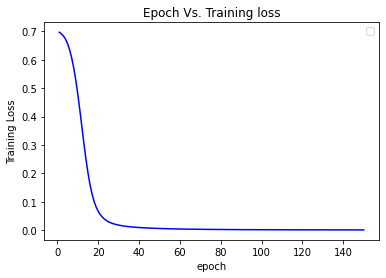

In [32]:
epoch_count = range(1, len(train_losses) + 1)
plt.plot(epoch_count, train_losses,'b')
plt.title('Epoch Vs. Training loss')
plt.ylabel('Training Loss')
plt.xlabel('epoch')
plt.legend()
plt.show()